# Multigrid

## Analyzing the Jacobi Method

In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg
import matplotlib.pyplot as plt

First, we create the A matrix.  For simplicity and easy of understanding, we will choose the 1D poisson problem.

In [113]:
N = 256
A = sp.diags([-1, 2, -1], [-1, 0, 1], shape=(N, N), dtype=np.double, format="csr")

For the sake of demonstration, we let the right-hand side vector $b$ correspond to the case of Dirichlet boundary conditions where both ends are held at $0$.  We choose this because the true solution is therefore the zero vector so the error corresponds exactly with the current iterate.

In [114]:
b = np.zeros((N,1), dtype=np.float64)

Let's generate some initial guesses (which are also initial errors) which are sine waves with varying frequencies.

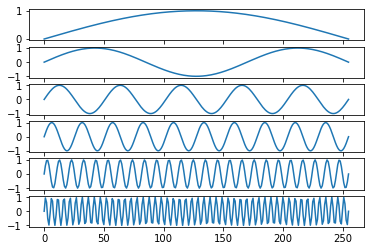

In [151]:
x = np.linspace(0,1,N)
waveNumbers = [1, 3, 10, 20, 50, 100]
xinitial = [np.sin(w*np.pi*x) for w in waveNumbers]
fig, axs = plt.subplots(len(waveNumbers),1)
for (i,p) in enumerate(xinitial):
    axs[i].plot(p)

We'll define our Jacobi function

In [152]:
def Jacobi(x, A, b, numiters=1):
    for i in range(numiters):
        # Need a copy of x since we'll be updating x in place
        xold = x.copy()
        
        # Loop through the rows
        for i in range(len(xold)):
            # Calculate the indices of the CSR data array that hold the row
            rowindices = range(A.indptr[i],A.indptr[i+1])
            
            r = sum([A.data[j]*xold[A.indices[j]] for j in rowindices if A.indices[j] != i])
            #for j in rowindices:
            #    col = A.indices[j]
            #    if col != i:
            #        r += A.data[j]*xold[col]
            
            # Update x
            x[i] = (b[i] - r)/A[i,i]

    return x

Now let's run 100 Jacobi iterations on each of these, tracking the error at each iteration.

In [153]:
numJacobiIters = 100
errors = [np.zeros((numJacobiIters+1,1), dtype=np.float64) for i in range(len(waveNumbers))]
for j in range(numJacobiIters+1):
    for (i, w) in enumerate(xinitial):
        if j == 0:
            errors[i][j] = np.linalg.norm(w)
        else:
            errors[i][j] = np.linalg.norm(Jacobi(w, A, b, 1))

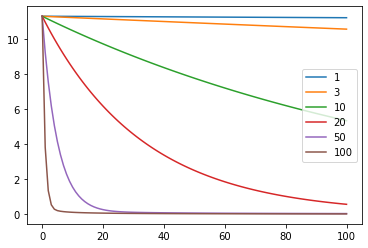

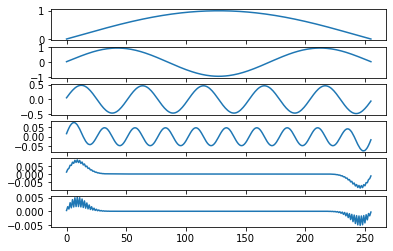

In [154]:
for (i,w) in enumerate(errors):
    plt.plot(w, label = waveNumbers[i])
plt.legend(loc="right")
plt.show()
fig, axs = plt.subplots(len(waveNumbers),1)
for (i,p) in enumerate(xinitial):
    axs[i].plot(p)

Here we see the key to understanding the effectiveness of multigrid.  The Jacobi iteration scheme is much better at eliminating high frequency error than low frequency error.

## How do we use this?
The Jacobi property of efficiently removing the high frequency error works independent of the length of the vector. Notice what happens if we start with a low frequency wave and approximate it with half as many points:

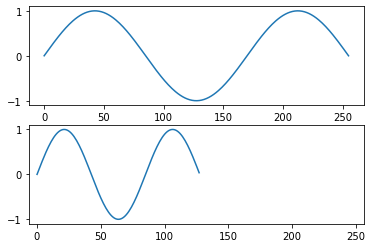

In [138]:
y_fine = np.sin(3*np.pi*x)
x_coarse = np.array([x[i] for i in range(len(x)) if i % 2 == 0])
y_coarse = np.sin(3*np.pi*x_coarse)
fig, axs = plt.subplots(2,1)
axs[0].plot(y_fine)
axs[1].plot(y_coarse)
plt.xlim(right=N)
plt.show()

Notice that the same number of waves now fit into half the length. This means that Jacobi iteration could be more effective on this new shorter vector.

## In Practice
Consider a discretized PDE problem on a grid (which we'll denote $\Omega^h$) where $h$ represents the spacing between nodes. As the name suggests, for the multigrid method we'll be using multiple grids, each with a different spacing of nodes. From here on, we'll be using superscript to denote which grid a quantity is on.

Our discretized problem is written as $A^h x^h = b^h$.  We'll start with $k$ Jacobi iterations. Since we don't expect our current iteration $x^h_k$ to be the exact solution, let's assume the exact solution is of the form $x^h_k + \varepsilon^h$.  This gives us an equation of the form:
\begin{equation*}
A^h(x^h_k + \varepsilon^h) = b^h
\end{equation*}
Rearranging this equation gives
\begin{equation*}
b^h - A^hx^h_k = A^h\varepsilon^h = r^h_k
\end{equation*}
So if we calculate $r^h_k$ and solve $A^h\varepsilon^h = r^h_k$ for $\varepsilon^h$, then we could find the exact solution as $x^h_k + \varepsilon^h$.

So how do we find or (more accurately) approximate $\varepsilon^h$?  Running more Jacobi iterations at this level has already shown to be less effective since the high frequency error has already been removed. Only the lower frequency error remains. Instead, we will move the problem down to a coarser grid, $\Omega^{2h}$. In the coarser grid, the low frequency error changes to higher frequency error and Jacobi can be more effective.

That is, we want to solve $A^{2h}e^{2h} = r^{2h}_k$, where $A^{2h}$, $e^{2h}$, and $r^{2h}_k$ are the \"coarse grid versions\" of $A^h$, $e^h$, and $r^h_k$. We will discuss how to find these later.

We can now use Jacobi on this equation and the high frequency error in $\Omega^{2h}$ (which is the lower frequency error in $\Omega^{h}$) will be removed.

After running iterations of Jacobi on $\Omega^{2h}$ to get an approximation for $e^{2h}$, we then \"transfer\" this back into the $\Omega^h$ grid and it becomes an approximation to $e^h$.  We then calculate $x^h_k + e^h$ to get a better approximation for $x^h_k$. In doing so, the transfer may have introduced more high frequency error, so we typically complete more Jacobi iterations at the fine level to remove these. This process leverages the change of grids to use Jacobi iteration more effectively.

## A Formal Two-Grid Cycle
Next stuff here.